# <a id='start'></a>  Germany post-processing short-term runs
In this Jupyter notebook, visualizations and analysis for a two day optimization are conducted (including stochastic dual dynamic programming (SDDP))

In this notebook the results of scenarios modelled with urbs are analysed and compared

* [Input](#input) 
* [Original urbs](#original)
* [SDDP urbs](#sddp)
* [Visualization of dispatch](#dispatch)
* [Visualization of CO$_2$ output](#co2)
* [Visualization of SOC](#soc)
* [Comparison of costs](#comp)


To run this notebook corretly, run the [Input](#input) part first!

***
***

## Input  <a id='input'></a> 
At first, needed packages are imported. Additionally, the input and global variables are defined.
(Back to [beginning](#start))

In [1]:
import os
import gurobipy as gp
import pandas as pd
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import re
from datetime import datetime

# map visualizations
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

# urbs package and self-written help scripts
import urbs
import define
import functions


%matplotlib notebook

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define input
folder_in = 'Input'
folder_out = 'Output'
subfolder = 'Visualization'
dt_h5 = '.h5'
dt_csv = '.csv'
dt_png = '.png'

h5_folder = 'h5_files'

datetime_origin = datetime(2015,1,1)

# some colors
tumblue = define.tumblue
tumblack = define.tumblack

# plot periods for dispatch
plot_periods = {'spring': ('2015-03-01', '2015-03-07'), 'summer': ('2015-06-01', '2015-06-07'),
                'autumn': ('2015-09-01', '2015-09-07'), 'winter': ('2015-12-01', '2015-12-07')}

plot_periods_num_mapper = {0: 'spring', 1: 'summer', 2: 'autumn', 3: 'winter'}

## Original urbs  <a id='original'></a> 
Analysis of original urbs
(Back to [beginning](#start))

In [3]:
folder = 'h5'
sub_folder_original = 'germany2015sddp-20190902T0949-two-day-january'#'germany2015sddp-20190510T1516-two-days-base-ls'
scenarios_original = ['scenario_base', 'scenario_ls'] # options: base, ls, ls_exp
h5_folder = 'h5_files'
path_original = os.path.join(folder, sub_folder_original, h5_folder)

# extract result dictionary from result container
rc_original = {}
for scenario in scenarios_original:
    scenario_path = os.path.join(path_original, f"original-{scenario}{dt_h5}")
    rc_original[scenario] = urbs.load(scenario_path)

In [4]:
# process and storage
e_pro_out_original = {}
e_sto_in_original = {}
e_sto_out_original = {}

for scenario in scenarios_original:
    # process
    help_df = rc_original[scenario]._result['e_pro_out'].xs('Elec', level='com').unstack().unstack()
    help_df = functions.summarize_plants(help_df)
    e_pro_out_original[scenario] = functions.set_date_index(help_df, datetime_origin)
    
    # storage in
    help_df = rc_original[scenario]._result['e_sto_in'].xs('Elec',
                                                       level='com').xs('Pumped storage',
                                                                       level='sto').unstack()
    e_sto_in_original[scenario] = functions.set_date_index(help_df, datetime_origin)

    # storage out
    help_df = rc_original[scenario]._result['e_sto_out'].xs('Elec',
                                                        level='com').xs('Pumped storage',
                                                                        level='sto').unstack()
    e_sto_out_original[scenario] = functions.set_date_index(help_df, datetime_origin)

In [5]:
# demand
demand_original = {}
demand_states_original = {}
for scenario in scenarios_original:
    # summed up demand
    help_df = rc_original[scenario]._data['demand'].xs('Elec', axis=1, level=1).sum(axis=1)
    demand_original[scenario] = functions.set_date_index(help_df, datetime_origin)

    # demand per state
    help_df = rc_original[scenario]._data['demand'].xs('Elec', axis=1, level=1)
    demand_states_original[scenario] = functions.set_date_index(help_df, datetime_origin)

In [6]:
#transmission
e_tra_in_original = {}
e_tra_out_original = {}

for scenario in scenarios_original:    
    # transmission in
    help_df = rc_original[scenario]._result['e_tra_in'].xs('Elec',
                                                           level='com').xs('hvac',
                                                                           level='tra').unstack().sum(axis=1).unstack()
    e_tra_in_original[scenario] = functions.set_date_index(help_df, datetime_origin)

    # transmission out
    help_df = rc_original[scenario]._result['e_tra_out'].xs('Elec',
                                                           level='com').xs('hvac',
                                                                           level='tra').unstack(level=1).sum(axis=1).unstack()
    e_tra_out_original[scenario] = functions.set_date_index(help_df, datetime_origin)

In [7]:
#  CO2
e_pro_co2_original = {}
for scenario in scenarios_original:
    help_df = rc_original[scenario]._result['e_pro_out'].xs('CO2', level='com').unstack().unstack()
    help_df = functions.summarize_plants(help_df)
    e_pro_co2_original[scenario] = functions.set_date_index(help_df, datetime_origin)

## SDDP urbs  <a id='sddp'></a> 
Analysis of urbs with uncertain scenarios for wind time series and SDDP approach
(Back to [beginning](#start))

In [8]:
folder = 'h5'
sub_folder_sddp = 'germany2015sddp-20190902T0949-two-day-january'#'germany2015sddp-20190510T1516-two-days-base-ls'
scenarios_sddp = ['scenario_base', 'scenario_ls'] # options: base, ls
h5_folder = 'h5_files'
path_sddp = os.path.join(folder, sub_folder_sddp, h5_folder)

realizations_sddp = ['mid']

result_files = functions.glob_result_files(path_sddp)

# derive list of h5 names for naming
h5_names = [os.path.basename(rf)  # drop folder names, keep filename
                #.replace(f'-iteration', '') # drop "iteration"
                .replace(f'.h5', '')  # drop file extension
                  for rf in result_files if 'scenario' in rf]

# list of names of all master and sub h5 files
h5_masters = [master for master in h5_names if ('master' in master and 'iteration' in master)]
h5_masters = sorted(h5_masters, key=lambda x: float(x.split('-')[2]))

# get maximum iteration number
max_iter_sddp = {
    item.split('-')[-1]: int(re.findall(r"\d+", item)[0])
    for item in h5_masters if len(re.findall(r"\d+", item)) > 0
}

# get all iterations
iterations_set = set(int(re.findall(r"\d+", item)[0])
    for item in h5_masters if len(re.findall(r"\d+", item)) > 0)

# dictionary of iterations per scenario
iterations_sddp = {
    scenario: sorted([iteration for iteration in iterations_set
                      for item in h5_masters
               if (iteration <= max_iter_sddp[scenario]
                  and str(iteration) in item
                  and scenario in item)])
               for scenario in max_iter_sddp.keys()
}

# read in result containers for master problems
rc_master_sddp = {}
for scenario in scenarios_sddp:
    for iteration in iterations_sddp[scenario]:
        help_path = [path for path in result_files
                     if all(items in path for items in [f"{scenario}", f"master",
                                                        str(iteration)])][0]
        rc_master_sddp[(scenario, iteration)] = urbs.load(help_path)
    help_path = [path for path in result_files
                     if all(items in path for items in [f"{scenario}", f"master"])
                     and 'iteration' not in path][0]
    rc_master_sddp[(scenario, 'end')] = urbs.load(help_path)

In [9]:
h5_subs = [sub for sub in h5_names if 'sub' in sub]
subs_sddp = set([int(re.findall(r"\d+", item)[0]) for item in h5_subs])

# read in result containers
rc_subs_sddp = {}
for scenario in scenarios_sddp:
    for sub in subs_sddp:
        for realization in realizations_sddp:
            for iteration in iterations_sddp[scenario]:
                help_path = [path for path in result_files
                             if all(items in path for items in [f"{scenario}",
                                                               f"sub({sub}",
                                                               realization,
                                                               str(iteration)])][0]
                rc_subs_sddp[(scenario, sub, realization, iteration)] = urbs.load(help_path)
            help_path = [path for path in result_files
                             if all(items in path for items in [f"{scenario}",
                                                               f"sub({sub}",
                                                               realization])
                        and 'iteration' not in path][0]
            rc_subs_sddp[(scenario, sub, realization, 'end')] = urbs.load(help_path)

In [10]:
e_pro_out_sddp = {}
for scenario in scenarios_sddp:
    for realization in ['mid']:
        for iteration in iterations_sddp[scenario]:
            help_df = functions.concatination('e_pro_out', rc_subs_sddp,
                                              scenario, realization, iteration,
                                              subs_sddp, rc_master_sddp)
            help_df = functions.summarize_plants(help_df)
            e_pro_out_sddp[(scenario, realization, iteration)] = functions.set_date_index(help_df,
                                                                                          datetime_origin)
            
        help_df = functions.concatination('e_pro_out', rc_subs_sddp, scenario, realization, 'end',
                                subs_sddp, rc_master=rc_master_sddp)
        help_df = functions.summarize_plants(help_df)
        e_pro_out_sddp[(scenario, realization, 'end')] = functions.set_date_index(help_df, datetime_origin)

In [11]:
# storages
e_sto_out_sddp = {}
for scenario in scenarios_sddp:
    for realization in ['mid']:
        for iteration in iterations_sddp[scenario]:
            help_df = functions.concatination('e_sto_out', rc_subs_sddp,
                                    scenario, realization, iteration, subs_sddp, rc_master_sddp)
            e_sto_out_sddp[(scenario, realization, iteration)] = functions.set_date_index(help_df, datetime_origin)
            
        help_df = functions.concatination('e_sto_out', rc_subs_sddp, scenario, realization, 'end', subs_sddp, rc_master=rc_master_sddp)
        e_sto_out_sddp[(scenario, realization, 'end')] = functions.set_date_index(help_df, datetime_origin)

e_sto_in_sddp = {}
for scenario in scenarios_sddp:
    for realization in ['mid']:
        for iteration in iterations_sddp[scenario]:
            help_df = functions.concatination('e_sto_in', rc_subs_sddp,
                                    scenario, realization, iteration, subs_sddp, rc_master_sddp)
            e_sto_in_sddp[(scenario, realization, iteration)] = functions.set_date_index(help_df, datetime_origin)
            
        help_df = functions.concatination('e_sto_in', rc_subs_sddp, scenario, realization, 'end', subs_sddp, rc_master=rc_master_sddp)
        e_sto_in_sddp[(scenario, realization, 'end')] = functions.set_date_index(help_df, datetime_origin)
        
e_sto_con_sddp = {}
for scenario in scenarios_sddp:
    for realization in ['mid']:
        for iteration in iterations_sddp[scenario]:
            help_df = functions.concatination('e_sto_con', rc_subs_sddp,
                                    scenario, realization, iteration, subs_sddp, rc_master_sddp)
            e_sto_con_sddp[(scenario, realization, iteration)] = functions.set_date_index(help_df, datetime_origin)
            
        help_df = functions.concatination('e_sto_con', rc_subs_sddp, scenario, realization, 'end', subs_sddp, rc_master=rc_master_sddp)
        e_sto_con_sddp[(scenario, realization, 'end')] = functions.set_date_index(help_df, datetime_origin)

In [12]:
#transmission

e_tra_out_sddp = {}
for scenario in scenarios_sddp:
    for realization in ['mid']:
        for iteration in iterations_sddp[scenario]:
            help_df = functions.concatination('e_tra_out', rc_subs_sddp,
                                    scenario, realization, iteration, subs_sddp, rc_master_sddp)
            e_tra_out_sddp[(scenario, realization, iteration)] = functions.set_date_index(help_df, datetime_origin)
            
        help_df = functions.concatination('e_tra_out', rc_subs_sddp, scenario, realization, 'end', subs_sddp, rc_master=rc_master_sddp)
        e_tra_out_sddp[(scenario, realization, 'end')] = functions.set_date_index(help_df, datetime_origin)

e_tra_in_sddp = {}
for scenario in scenarios_sddp:
    for realization in ['mid']:
        for iteration in iterations_sddp[scenario]:
            help_df = functions.concatination('e_tra_in', rc_subs_sddp,
                                    scenario, realization, iteration, subs_sddp, rc_master_sddp)
            e_tra_in_sddp[(scenario, realization, iteration)] = functions.set_date_index(help_df, datetime_origin)
            
        help_df = functions.concatination('e_tra_in', rc_subs_sddp, scenario, realization, 'end', subs_sddp, rc_master=rc_master_sddp)
        e_tra_in_sddp[(scenario, realization, 'end')] = functions.set_date_index(help_df, datetime_origin)

In [13]:
# CO2
e_pro_co2_sddp = {}
for scenario in scenarios_sddp:
    for realization in ['mid']:
        for iteration in iterations_sddp[scenario]:
            help_df = functions.concatination('e_pro_out', rc_subs_sddp,
                                    scenario, realization, iteration, subs_sddp, rc_master_sddp, com='CO2')
            help_df = functions.summarize_plants(help_df)
            e_pro_co2_sddp[(scenario, realization, iteration)] = functions.set_date_index(help_df, datetime_origin)
            
        help_df = functions.concatination('e_pro_out', rc_subs_sddp, scenario, realization,
                                'end', subs_sddp, rc_master_sddp, com='CO2')
        help_df = functions.summarize_plants(help_df)
        e_pro_co2_sddp[(scenario, realization, 'end')] = functions.set_date_index(help_df, datetime_origin)

## Visualization of dispatch<a id='dispatch'></a> 
Compare CO$_2$ output for sddp and original approach
(Back to [beginning](#start))

In [14]:
# process and storage
# perfect foresight
e_pro_out_original = {}
e_sto_in_original = {}
e_sto_out_original = {}

for scenario in scenarios_original:
    # process
    help_df = rc_original[scenario]._result['e_pro_out'].xs('Elec', level='com').unstack().unstack()
    help_df = functions.summarize_plants(help_df)
    e_pro_out_original[scenario] = functions.set_date_index(help_df, datetime_origin)
    
    # storage in
    help_df = rc_original[scenario]._result['e_sto_in'].xs('Elec',
                                                       level='com').xs('Pumped storage',
                                                                       level='sto').unstack()
    e_sto_in_original[scenario] = functions.set_date_index(help_df, datetime_origin)

    # storage out
    help_df = rc_original[scenario]._result['e_sto_out'].xs('Elec',
                                                        level='com').xs('Pumped storage',
                                                                        level='sto').unstack()
    e_sto_out_original[scenario] = functions.set_date_index(help_df, datetime_origin)

    
# sddp
e_pro_out_sddp = {}
e_sto_out_sddp = {}
e_sto_in_sddp = {}
for scenario in scenarios_sddp:
    for realization in ['mid']:
        for iteration in iterations_sddp[scenario]:
            # process
            help_df = functions.concatination('e_pro_out', rc_subs_sddp,
                                              scenario, realization, iteration,
                                              subs_sddp, rc_master_sddp)
            help_df = functions.summarize_plants(help_df)
            e_pro_out_sddp[(scenario, realization, iteration)] = functions.set_date_index(help_df,
                                                                                          datetime_origin)
            
            # storage out
            help_df = functions.concatination('e_sto_out', rc_subs_sddp,
                                    scenario, realization, iteration, subs_sddp, rc_master_sddp)
            e_sto_out_sddp[(scenario, realization, iteration)] = functions.set_date_index(help_df, datetime_origin)
            
            # storage in
            help_df = functions.concatination('e_sto_in', rc_subs_sddp,
                                    scenario, realization, iteration, subs_sddp, rc_master_sddp)
            e_sto_in_sddp[(scenario, realization, iteration)] = functions.set_date_index(help_df, datetime_origin)
        
        # last iteration
        
        # process
        help_df = functions.concatination('e_pro_out', rc_subs_sddp, scenario, realization, 'end',
                                subs_sddp, rc_master=rc_master_sddp)
        help_df = functions.summarize_plants(help_df)
        e_pro_out_sddp[(scenario, realization, 'end')] = functions.set_date_index(help_df, datetime_origin)
        
        # storage out
        help_df = functions.concatination('e_sto_out', rc_subs_sddp, scenario, realization, 'end', subs_sddp, rc_master=rc_master_sddp)
        e_sto_out_sddp[(scenario, realization, 'end')] = functions.set_date_index(help_df, datetime_origin)
        
        # storage in
        help_df = functions.concatination('e_sto_in', rc_subs_sddp, scenario, realization, 'end', subs_sddp, rc_master=rc_master_sddp)
        e_sto_in_sddp[(scenario, realization, 'end')] = functions.set_date_index(help_df, datetime_origin)        

In [15]:
# demand (for both sddp and perfect foresight as demand is a constant input)
demand_original = {}
demand_states_original = {}
for scenario in scenarios_original:
    # summed up demand
    help_df = rc_original[scenario]._data['demand'].xs('Elec', axis=1, level=1).sum(axis=1)
    demand_original[scenario] = functions.set_date_index(help_df, datetime_origin)

    # demand per state
    help_df = rc_original[scenario]._data['demand'].xs('Elec', axis=1, level=1)
    demand_states_original[scenario] = functions.set_date_index(help_df, datetime_origin)

In [16]:
#transmission

# perfect foresight
e_tra_in_original = {}
e_tra_out_original = {}

for scenario in scenarios_original:    
    # transmission in
    help_df = rc_original[scenario]._result['e_tra_in'].xs('Elec',
                                                           level='com').xs('hvac',
                                                                           level='tra').unstack().sum(axis=1).unstack()
    e_tra_in_original[scenario] = functions.set_date_index(help_df, datetime_origin)

    # transmission out
    help_df = rc_original[scenario]._result['e_tra_out'].xs('Elec',
                                                           level='com').xs('hvac',
                                                                           level='tra').unstack(level=1).sum(axis=1).unstack()
    e_tra_out_original[scenario] = functions.set_date_index(help_df, datetime_origin)
    
# sddp

e_tra_out_sddp = {}
e_tra_in_sddp = {}

for scenario in scenarios_sddp:
    for realization in ['mid']:
        for iteration in iterations_sddp[scenario]:
            #transmission out
            help_df = functions.concatination('e_tra_out', rc_subs_sddp,
                                    scenario, realization, iteration, subs_sddp, rc_master_sddp)
            e_tra_out_sddp[(scenario, realization, iteration)] = functions.set_date_index(help_df, datetime_origin)
            
            # transmission in
            help_df = functions.concatination('e_tra_in', rc_subs_sddp,
                                    scenario, realization, iteration, subs_sddp, rc_master_sddp)
            e_tra_in_sddp[(scenario, realization, iteration)] = functions.set_date_index(help_df, datetime_origin)
            
        # last iteration
        
        # transmission out
        help_df = functions.concatination('e_tra_out', rc_subs_sddp, scenario, realization, 'end', subs_sddp, rc_master=rc_master_sddp)
        e_tra_out_sddp[(scenario, realization, 'end')] = functions.set_date_index(help_df, datetime_origin)
        
        # tranmission in
        help_df = functions.concatination('e_tra_in', rc_subs_sddp, scenario, realization, 'end', subs_sddp, rc_master=rc_master_sddp)
        e_tra_in_sddp[(scenario, realization, 'end')] = functions.set_date_index(help_df, datetime_origin)

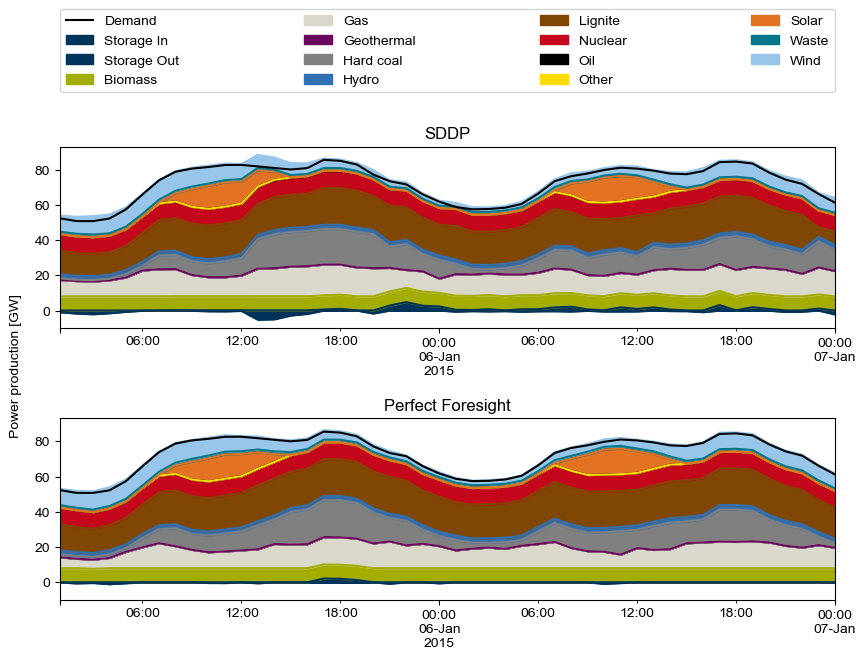

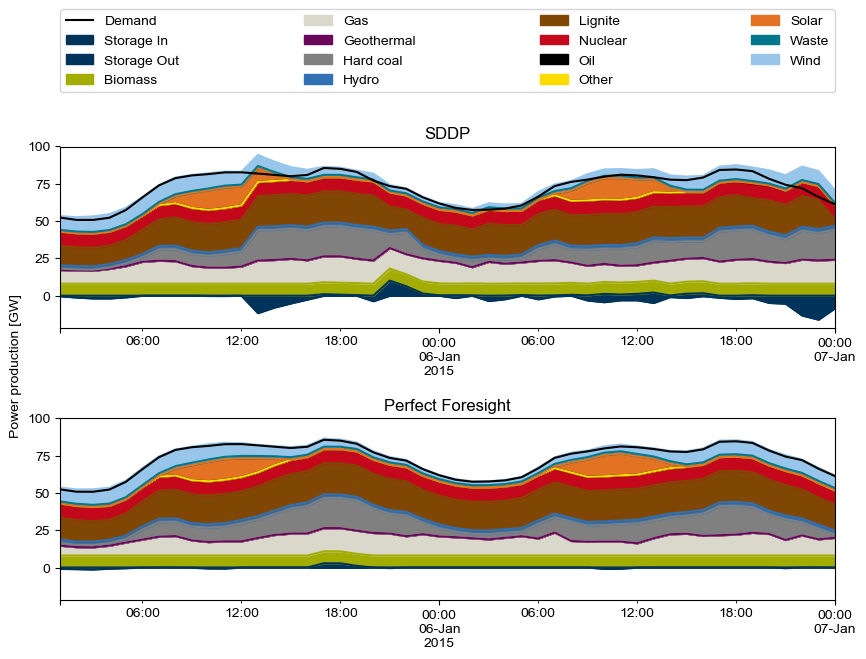

In [17]:
iteration_list = ['end']


for scenario in scenarios_sddp:
    
    fig, ax = plt.subplots(nrows = len(iteration_list)+1, figsize=(10,6), dpi=100, sharey=True)

    # Set space between subplots
    fig.subplots_adjust(hspace = 0.5) 
    
    for iteration in iteration_list:
        help_index = iteration_list.index(iteration)
        # plot produced power and storage shiftings as stacked area plot
        e_pro = e_pro_out_sddp[(scenario, 'mid', iteration)].sum(axis=1, level=0)
        e_pro.rename(columns=define.translate_fuel,inplace=True)
        sto_out = e_sto_out_sddp[(scenario, 'mid', iteration)].sum(axis=1)
        sto_out.rename('Storage Out', inplace=True)
        sto_in = -e_sto_in_sddp[(scenario, 'mid', iteration)].sum(axis=1).clip(lower=0)
        sto_in.rename('Storage In', inplace=True)
        plot_element = pd.concat([sto_in, sto_out, e_pro], axis=1)
        (plot_element/1000).plot(kind='area', stacked=True, ax=ax[help_index],
                                 legend=False, color=define.color_fuels.values())

        # plot demand
        plot_element = demand_original[scenario][plot_element.index]
        plot_element.rename('Demand', inplace=True)
        (plot_element/1000).plot(ax=ax[help_index], color=tumblack)

        #axis_thousand_comma(ax[help_index], ['y'])
        ax[help_index].set_xlabel('')
        ax[help_index].set_title(f'SDDP')

    # plot original
    help_index = len(iteration_list)
    # plot produced power and storage shiftings as stacked area plot
    e_pro = e_pro_out_original[scenario].sum(axis=1, level=0)
    e_pro.rename(columns=define.translate_fuel,inplace=True)
    sto_out = e_sto_out_original[scenario].sum(axis=1)
    sto_out.rename('Storage Out', inplace=True)
    sto_in = -e_sto_in_original[scenario].sum(axis=1).clip(lower=0)
    sto_in.rename('Storage In', inplace=True)
    plot_element = pd.concat([sto_in, sto_out, e_pro], axis=1)
    (plot_element/1000).plot(kind='area', stacked=True, ax=ax[help_index],
                                 legend=False, color=define.color_fuels.values())

    # plot demand
    plot_element = demand_original[scenario][plot_element.index]
    plot_element.rename('Demand', inplace=True)
    (plot_element/1000).plot(ax=ax[help_index], color=tumblack)

    ax[help_index].set_xlabel('')
    ax[help_index].set_title(f'Perfect Foresight')

    fig.text(0.075, 0.62, 'Power production [GW]', rotation=90)
    functions.legend_above(ax[0])

    plt.savefig(os.path.join(folder_out, subfolder, f'application-short-term-e_pro_out-{scenario}-Germany.png'),
                bbox_inches='tight', dpi=600)

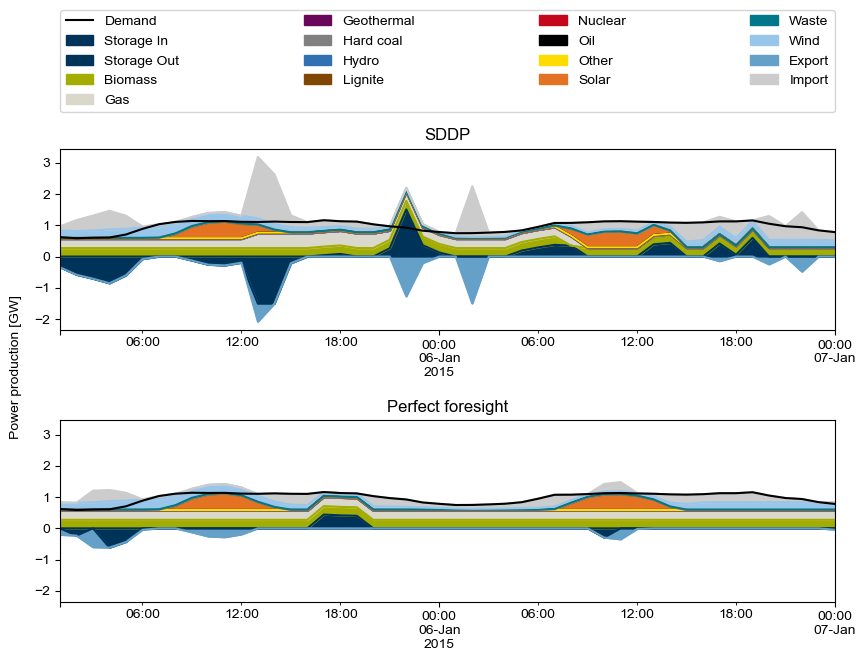

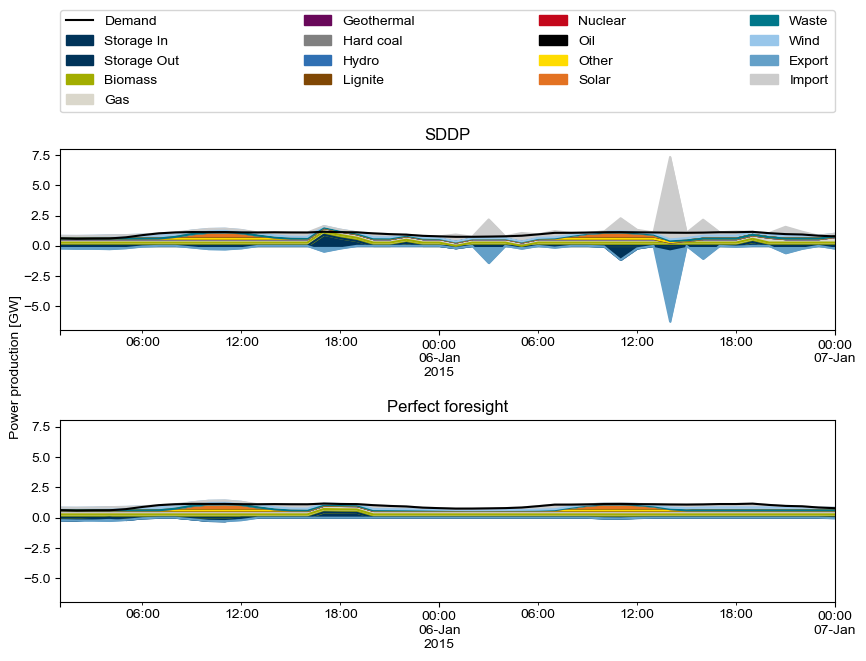

In [18]:
iteration_list = ['end'] #iterations_sddp[fscenario] + ['end']



state = 'Thuringia'

realization = 'mid'

for scenario in scenarios_sddp:
    fig, ax = plt.subplots(nrows = len(iteration_list)+1, figsize=(10,6), dpi=100, sharey=True)

    # Set space between subplots
    fig.subplots_adjust(hspace = .5) 

    for iteration in iteration_list:
        help_index = iteration_list.index(iteration)
        # plot produced power and storage shiftings as stacked area plot
        e_pro = e_pro_out_sddp[(scenario, realization, iteration)].xs(state, axis=1, level='sit')
        e_pro.rename(columns=define.translate_fuel,inplace=True)
        sto_out = e_sto_out_sddp[(scenario, realization, iteration)][state]
        sto_out.rename('Storage Out', inplace=True)
        sto_in = -e_sto_in_sddp[(scenario, realization, iteration)][state]
        sto_in.rename('Storage In', inplace=True)
        tra_in = -e_tra_in_sddp[(scenario, realization, iteration)][state]
        tra_in.rename('Export', inplace=True)
        tra_out = e_tra_out_sddp[(scenario, realization, iteration)][state]
        tra_out.rename('Import', inplace=True)
        plot_element = pd.concat([sto_in, sto_out, e_pro, tra_in, tra_out], axis=1)
        (plot_element/1000).plot(kind='area', stacked=True, ax=ax[help_index],
                                 legend=False, color=list(define.color_fuels.values())+ ['#00778a', '#CAAB29'])

        # plot demand
        plot_element = demand_states_original[scenario][state][plot_element.index]
        plot_element.rename('Demand', inplace=True)
        (plot_element/1000).plot(ax=ax[help_index], color=tumblack)

        #axis_thousand_comma(ax[help_index], ['y'])
        ax[help_index].set_xlabel('')
        ax[help_index].set_title(f'SDDP')

    # plot original
    help_index = len(iteration_list)
    # plot produced power and storage shiftings as stacked area plot
    e_pro = e_pro_out_original[scenario].xs(state, axis=1, level='sit')
    e_pro.rename(columns=define.translate_fuel,inplace=True)
    sto_out = e_sto_out_original[scenario][state]
    sto_out.rename('Storage Out', inplace=True)
    sto_in = -e_sto_in_original[scenario][state]
    sto_in.rename('Storage In', inplace=True)
    tra_in = -e_tra_in_original[scenario][state]
    tra_in.rename('Export', inplace=True)
    tra_out = e_tra_out_original[scenario][state]
    tra_out.rename('Import', inplace=True)
    plot_element = pd.concat([sto_in, sto_out, e_pro, tra_in, tra_out], axis=1)
    (plot_element/1000).plot(kind='area', stacked=True, ax=ax[help_index],
                                 legend=False, color=list(define.color_fuels.values())+ ['#00778a', '#CAAB29'])

    # plot demand
    plot_element = demand_states_original[scenario][state][plot_element.index]
    plot_element.rename('Demand', inplace=True)
    (plot_element/1000).plot(ax=ax[help_index], color=tumblack)

    fig.text(0.075, 0.62, 'Power production [GW]', rotation=90)
    
    #axis_thousand_comma(ax[help_index], ['y'])
    ax[help_index].set_xlabel('')
    ax[help_index].set_title(f'Perfect foresight')

    functions.legend_above(ax[0], anchorbox=(0., 1.2, 1., .102))

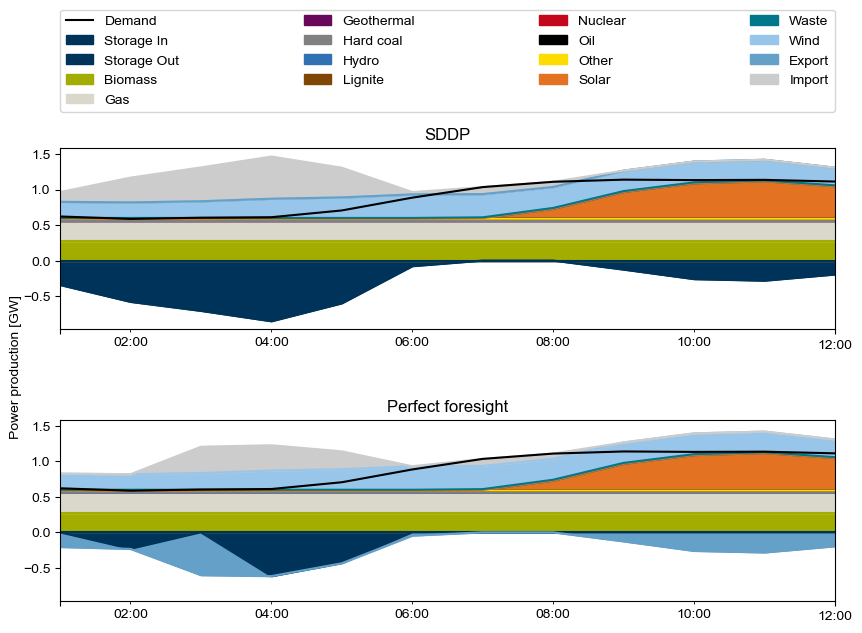

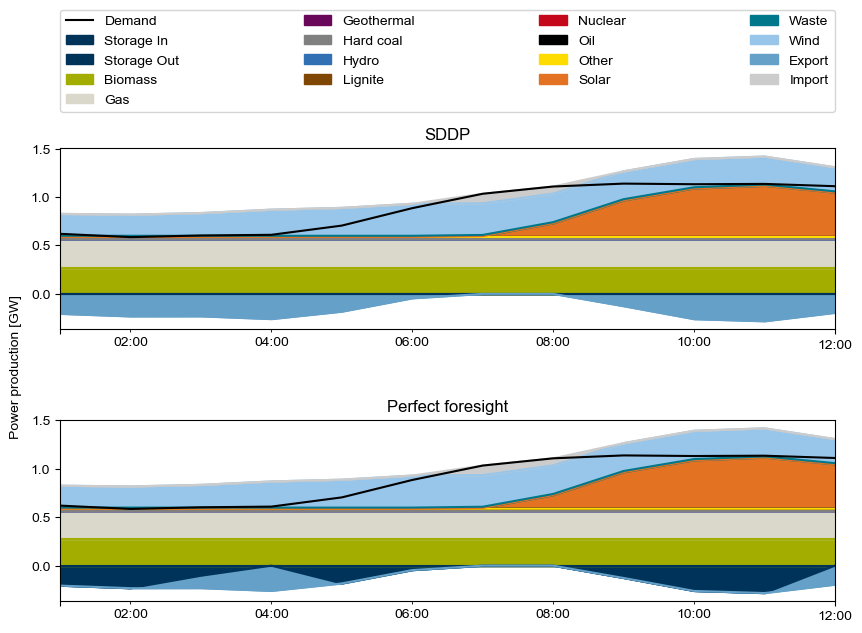

In [19]:
iteration_list = ['end']

state = 'Thuringia'
realization = 'mid'
period = ['2015-01-05 01:00', '2015-01-05 12:00']

for scenario in scenarios_sddp:
    fig, ax = plt.subplots(nrows = len(iteration_list)+1, figsize=(10,6), dpi=100, sharey=True)

    # Set space between subplots
    fig.subplots_adjust(hspace = .5) 

    
    for iteration in iteration_list:
        help_index = iteration_list.index(iteration)
        # plot produced power and storage shiftings as stacked area plot
        e_pro = e_pro_out_sddp[(scenario, realization, iteration)].xs(state, axis=1, level='sit')
        e_pro.rename(columns=define.translate_fuel,inplace=True)
        sto_out = e_sto_out_sddp[(scenario, realization, iteration)][state]
        sto_out.rename('Storage Out', inplace=True)
        sto_in = -e_sto_in_sddp[(scenario, realization, iteration)][state]
        sto_in.rename('Storage In', inplace=True)
        tra_in = -e_tra_in_sddp[(scenario, realization, iteration)][state]
        tra_in.rename('Export', inplace=True)
        tra_out = e_tra_out_sddp[(scenario, realization, iteration)][state]
        tra_out.rename('Import', inplace=True)
        plot_element = pd.concat([sto_in, sto_out, e_pro, tra_in, tra_out], axis=1)[period[0]:period[1]]
        (plot_element/1000).plot(kind='area', stacked=True, ax=ax[help_index],
                                 legend=False, color=list(define.color_fuels.values())+ ['#00778a', '#CAAB29'])

        # plot demand
        plot_element = demand_states_original[scenario][state][plot_element.index]
        plot_element.rename('Demand', inplace=True)
        (plot_element/1000).plot(ax=ax[help_index], color=tumblack)

        #axis_thousand_comma(ax[help_index], ['y'])
        ax[help_index].set_xlabel('')
        ax[help_index].set_title(f'SDDP')

    # plot original
    help_index = len(iteration_list)
    # plot produced power and storage shiftings as stacked area plot
    e_pro = e_pro_out_original[scenario].xs(state, axis=1, level='sit')
    e_pro.rename(columns=define.translate_fuel,inplace=True)
    sto_out = e_sto_out_original[scenario][state]
    sto_out.rename('Storage Out', inplace=True)
    sto_in = -e_sto_in_original[scenario][state]
    sto_in.rename('Storage In', inplace=True)
    tra_in = -e_tra_in_original[scenario][state]
    tra_in.rename('Export', inplace=True)
    tra_out = e_tra_out_original[scenario][state]
    tra_out.rename('Import', inplace=True)
    plot_element = pd.concat([sto_in, sto_out, e_pro, tra_in, tra_out], axis=1)[period[0]:period[1]]
    (plot_element/1000).plot(kind='area', stacked=True, ax=ax[help_index],
                                 legend=False, color=list(define.color_fuels.values())+ ['#00778a', '#CAAB29'])

    # plot demand
    plot_element = demand_states_original[scenario][state][plot_element.index]
    plot_element.rename('Demand', inplace=True)
    (plot_element/1000).plot(ax=ax[help_index], color=tumblack)

    ax[help_index].set_xlabel('')
    ax[help_index].set_title(f'Perfect foresight')
    
    fig.text(0.075, 0.62, 'Power production [GW]', rotation=90)

    functions.legend_above(ax[0], anchorbox=(0., 1.2, 1., .102))

    plt.savefig(os.path.join(folder_out, subfolder, f'application-short-term-e_pro_out-{scenario}-{state}.png'),
                bbox_inches='tight', dpi=600)

## Visualization of CO$_2$ emissions<a id='co2'></a> 
Compare CO$_2$ output for sddp and original approach
(Back to [beginning](#start))

In [20]:
#  CO2
e_pro_co2_original = {}
for scenario in scenarios_original:
    help_df = rc_original[scenario]._result['e_pro_out'].xs('CO2', level='com').unstack().unstack()
    help_df = functions.summarize_plants(help_df)
    e_pro_co2_original[scenario] = functions.set_date_index(help_df, datetime_origin)

In [21]:
# CO2
e_pro_co2_sddp = {}
for scenario in scenarios_sddp:
    for realization in ['mid']:
        for iteration in iterations_sddp[scenario]:
            help_df = functions.concatination('e_pro_out', rc_subs_sddp,
                                    scenario, realization, iteration, subs_sddp, rc_master_sddp, com='CO2')
            help_df = functions.summarize_plants(help_df)
            e_pro_co2_sddp[(scenario, realization, iteration)] = functions.set_date_index(help_df, datetime_origin)
            
        help_df = functions.concatination('e_pro_out', rc_subs_sddp, scenario, realization,
                                'end', subs_sddp, rc_master_sddp, com='CO2')
        help_df = functions.summarize_plants(help_df)
        e_pro_co2_sddp[(scenario, realization, 'end')] = functions.set_date_index(help_df, datetime_origin)

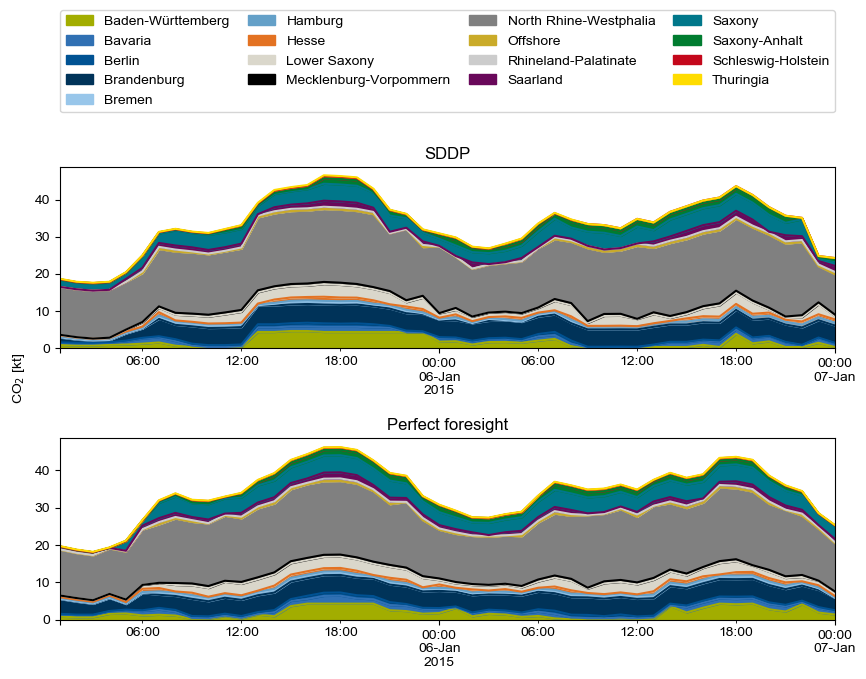

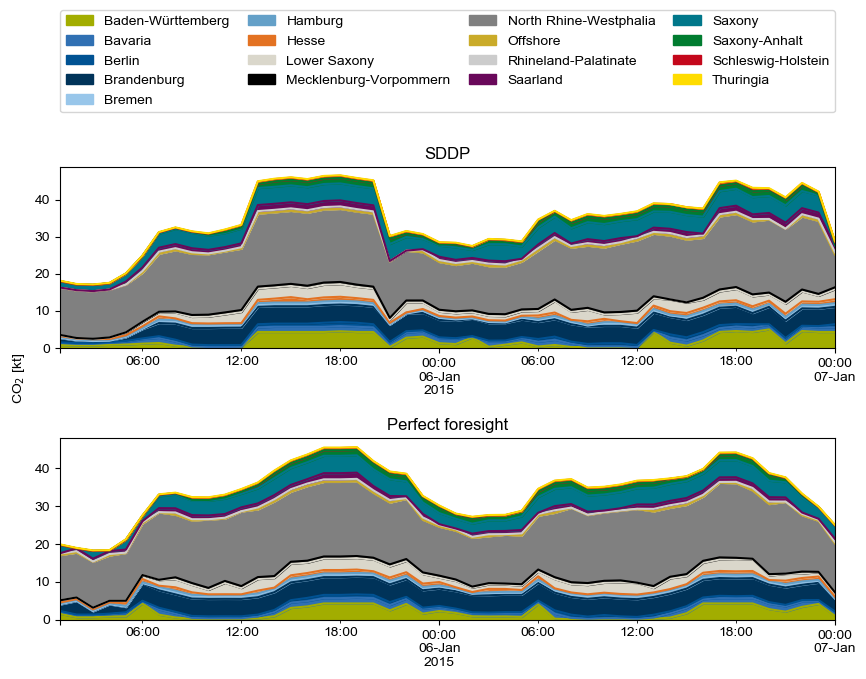

In [22]:
iteration_list = ['end']

for scenario in scenarios_sddp:
    for realization in ['mid']:
        fig, ax = plt.subplots(nrows = len(iteration_list)+1, figsize=(10,6), dpi=100)

        # Set space between subplots
        fig.subplots_adjust(hspace = 0.5) 

        for iteration in iteration_list:
            help_index = iteration_list.index(iteration)
            # plot produced power and storage shiftings as stacked area plot
            plot_element = e_pro_co2_sddp[(scenario, realization, iteration)].sum(axis=1, level=1)
            (plot_element/1000).plot(kind='area', stacked=True, ax=ax[help_index],
                                     legend=False, color=define.color_states.values())

            ax[help_index].set_xlabel('')
            ax[help_index].set_title(f'SDDP')

        # plot original
        help_index = len(iteration_list)
        # plot produced power and storage shiftings as stacked area plot
        plot_element = e_pro_co2_original[scenario].sum(axis=1, level=1)
        (plot_element/1000).plot(kind='area', stacked=True, ax=ax[help_index],
                                     legend=False, color=define.color_states.values())

        ax[help_index].set_xlabel('')
        ax[help_index].set_title(f'Perfect foresight')
        fig.text(0.075, 0.55, 'CO$_2$ [kt]', rotation=90)
        
        functions.legend_above(ax[0])
        plt.savefig(os.path.join(folder_out, subfolder,
                                 f'application-short-term-e_co2_out-{scenario}-Germany.png'),
                    bbox_inches='tight', dpi=600)

## Visualization of SOC<a id='storage'></a> 
Compare SOC for sddp and original approach
(Back to [beginning](#start))

In [23]:
# storage content
e_sto_con_original = {}
e_sto_con_sddp = {}

for scenario in scenarios_sddp:
    # perfect foresight
    help_df = rc_original[scenario]._result['e_sto_con'].xs('Elec',
                                                        level='com').xs('Pumped storage',
                                                                        level='sto').unstack()
    e_sto_con_original[scenario] = functions.set_date_index(help_df, datetime_origin)
    
    # sddp
    for realization in ['mid']:
        for iteration in iterations_sddp[scenario]:
            help_df = functions.concatination('e_sto_con', rc_subs_sddp,
                                    scenario, realization, iteration, subs_sddp, rc_master_sddp)
            e_sto_con_sddp[(scenario, realization, iteration)] = functions.set_date_index(help_df, datetime_origin)
            
        help_df = functions.concatination('e_sto_con', rc_subs_sddp, scenario, realization, 'end', subs_sddp, rc_master=rc_master_sddp)
        e_sto_con_sddp[(scenario, realization, 'end')] = functions.set_date_index(help_df, datetime_origin)

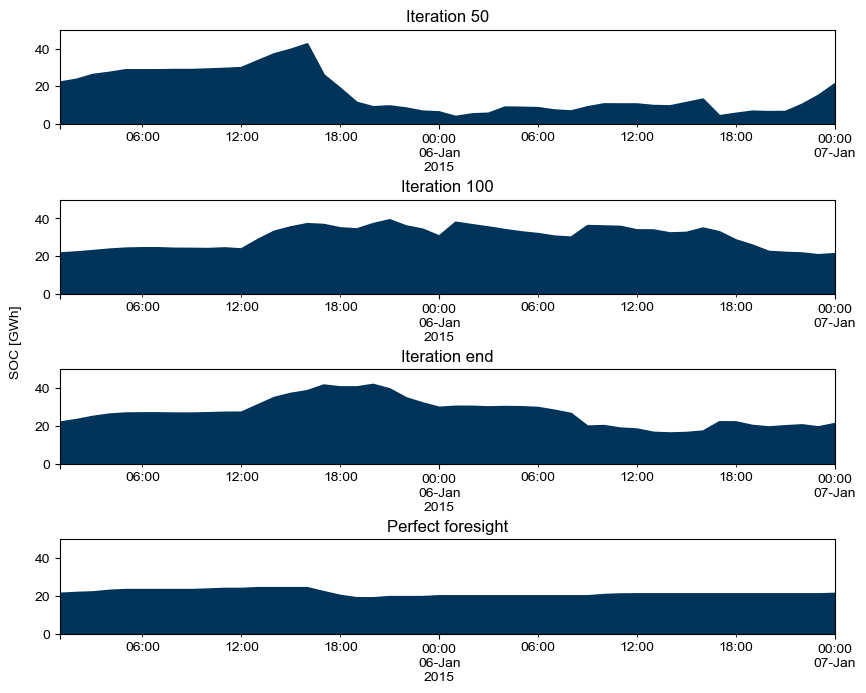

In [24]:
iteration_list = [50, 100, 'end']

fig, ax = plt.subplots(nrows = len(iteration_list)+1, figsize=(10,8), dpi=100, sharey=True)#, squeeze=False)

# Set space between subplots
fig.subplots_adjust(hspace = 0.8) 

for iteration in iteration_list:
    help_index = iteration_list.index(iteration)
    plot_element = e_sto_con_sddp[('scenario_base', 'mid', iteration)].sum(axis=1)
    (plot_element/1000).plot.area(ax = ax[help_index], legend=False, color=define.tumdarkblue)
    ax[help_index].set_title(f'Iteration {iteration}')
    ax[help_index].set_xlabel('')
    ax[help_index].set_ylim([0,50])
    ax[help_index].set_xlim([plot_element.index[0], plot_element.index[-1]])
    
# plot deterministic
help_index = len(iteration_list)
plot_element = e_sto_con_original['scenario_base'].sum(axis=1)[1:]
(plot_element/1000).plot.area(ax = ax[help_index], legend=False, color=define.tumdarkblue)
 
ax[help_index].set_title(f'Perfect foresight')
ax[help_index].set_xlabel('')
ax[help_index].set_xlim([plot_element.index[0], plot_element.index[-1]])
    
fig.text(0.075, 0.525, 'SOC [GWh]', rotation=90)

plt.savefig(os.path.join(folder_out, subfolder,
                         f'application-short-term-e_sto_con-scenario-base-Germany.png'),
            bbox_inches='tight', dpi=600)

## Comparison of costs  <a id='comp'></a> 
Compare costs for sddp and original approach
(Back to [beginning](#start))

In [25]:
rc_original['scenario_base']._result['costs'].sum() - rc_master_sddp[('scenario_base', 'end')]._result['costs'].sum()

-294803184.0299988

In [26]:
rc_original['scenario_base']._result['costs'].sum()

14167956051.67

In [27]:
rc_master_sddp[('scenario_base', 'end')]._result['costs'].sum()

14462759235.699999

In [28]:
rc_original['scenario_ls']._result['costs'].sum() - rc_master_sddp[('scenario_ls', 'end')]._result['costs'].sum()

-289820107.80999947

In [29]:
rc_master_sddp[('scenario_ls', 'end')]._result['costs'].sum()

14623807674.619999